In [1]:
%matplotlib inline
import numpy as np
import math, random, copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm


actual_landmarks = [np.array([-0.5, 0.0]), np.array([0.5, 0.0]), np.array([0.0, 0.5])]

class Particle:
    def __init__(self, p, w):
        self.pose = np.array(p)
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)

In [2]:
def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old            
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw, act_fw / 10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot, act_rot / 10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x, pos_y, pos_theta])

In [3]:
def relative_landmark_pos(pose, landmark):
    x,y,theta = pose
    lx,ly = landmark
    
    distance = math.sqrt((x - lx)**2 + (y - ly)**2)
    direction = math.atan2(ly - y, lx - x) - theta
    
    return (distance, direction, lx, ly)

def observation(pose, landmark):
    actual_distance, actual_direction, lx, ly = relative_landmark_pos(pose, landmark)
    
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance, actual_distance * 0.1)  
    measured_direction = random.gauss(actual_direction, 5.0 / 180.0 * math.pi)  
    
    return (measured_distance, measured_direction, lx, ly)

def observations(pose,landmarks):
    return list(filter(lambda x: x != None, [ observation(pose, e) for e in landmarks]))

In [4]:
def likelihood(pose, measurement):
    x, y, theta = pose
    distance, direction, lx, ly = measurement
    
    rel_distance, rel_direction,tmp_x, tmp_y = relative_landmark_pos(pose, [lx, ly])
    
    tmp_wdis = norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)
    tmp_wdir = norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0 / 180.0 * math.pi)
    
    return tmp_wdis*tmp_wdir

def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    ws = [ p.weight for p in particles ]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s

In [5]:
def resampling(particles):
    accum = []
    sm = 0.0
    for p in particles:
        accum.append(p.weight + sm)
        sm += p.weight
        
    pointer = random.uniform(0.0, 1.0 / len(particles))
    
    new_particles = []
    particles_num = len(particles)
    
    while pointer < 1.0:
        if accum[0] >= pointer:
            new_particles.append(
                Particle(copy.deepcopy(particles[0].pose), 1.0 / particles_num)
            )
            pointer += 1.0 / particles_num
        else:
            accum.pop(0)
            particles.pop(0)
        
    return new_particles

In [6]:
def draw(pose,particles):    
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect = 'equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2]) for e in particles]
    vys = [math.sin(e.pose[2]) for e in particles]
    plt.quiver(xs, ys, vxs, vys, color = "blue", label = "particles")
    
    plt.quiver([pose[0]], [pose[1]], [math.cos(pose[2])], [math.sin(pose[2])], color = "red", label = "actual")
    
def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs, ys, s=300, marker = "*", label = "landmarks", color = "orange")
    
def draw_observation(pose,measurement):
    x,y,theta = pose
    mdistance, mdirection, tmp_x, tmp_y = measurement
    
    lx = x + mdistance * math.cos(theta + mdirection)
    ly = y + mdistance * math.sin(theta + mdirection)
    
    plt.plot([pose[0], lx], [pose[1], ly], color = "pink")   

def draw_observations(pose, measurements):
    for m in measurements:
        draw_observation(pose, m)

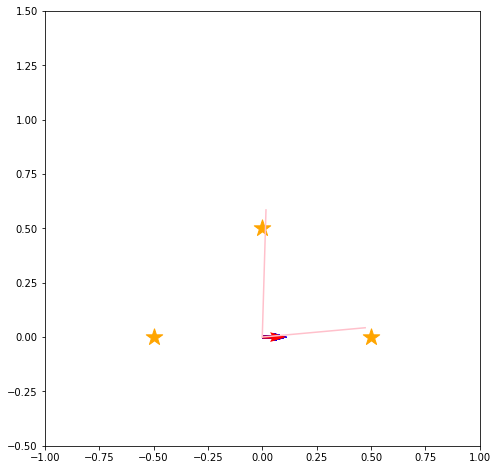

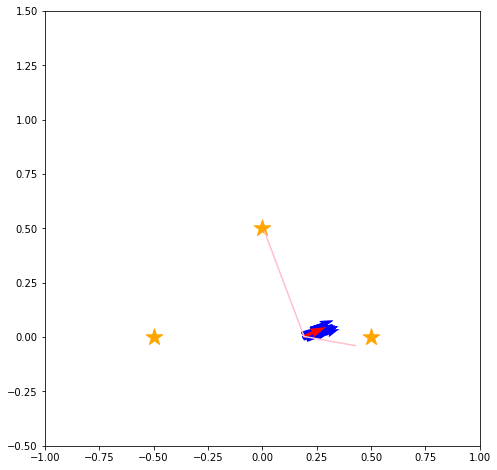

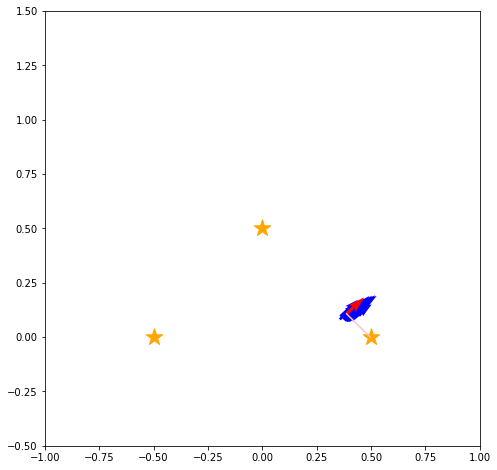

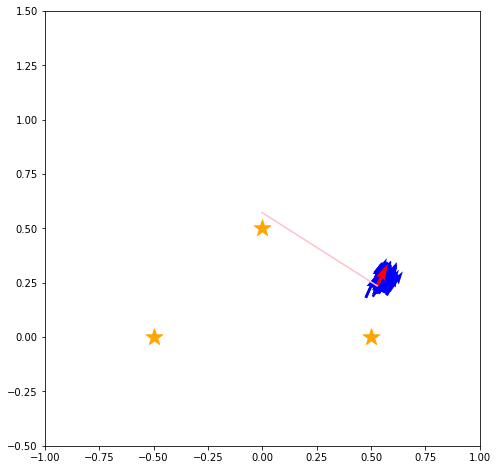

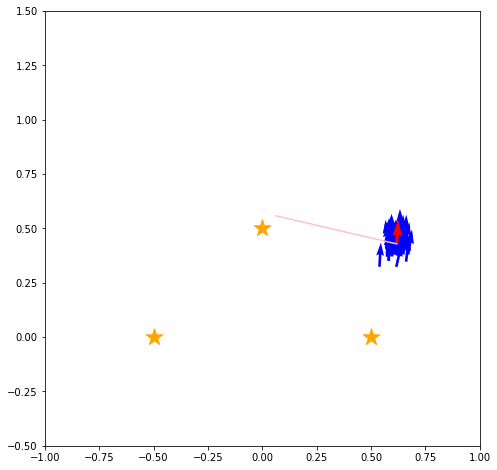

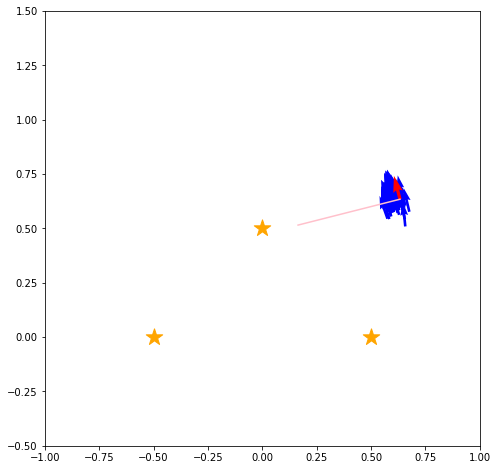

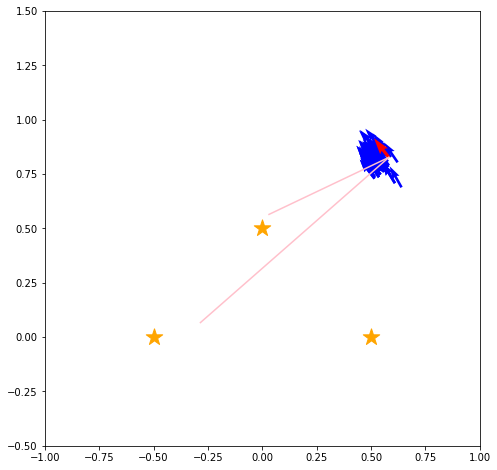

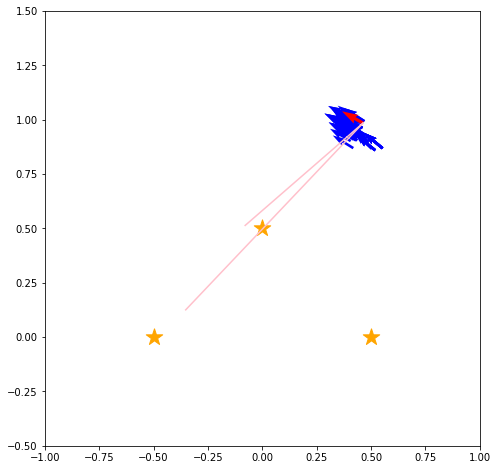

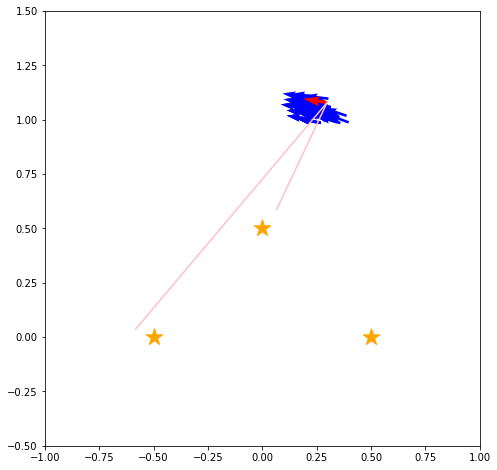

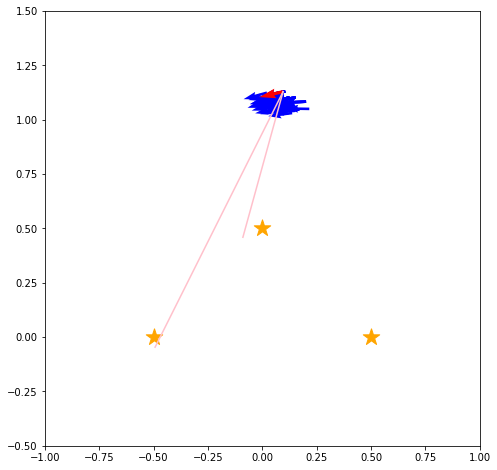

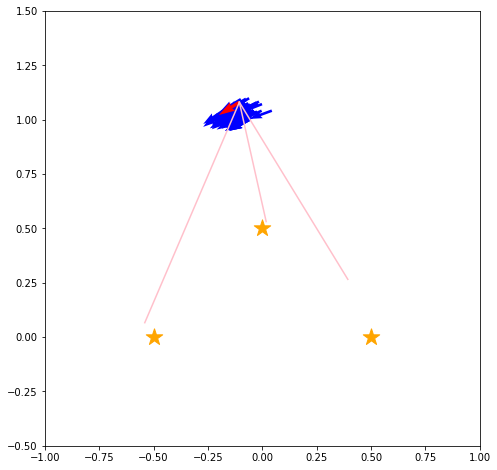

In [7]:
actual_x = np.array([0.0, 0.0, 0.0])
particles = [Particle(actual_x, 1.0 / 100) for i in range(100)]
u = np.array([0.2, math.pi / 180.0 * 20.0])

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]

for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    
    for p in particles:
        p.pose = f(p.pose,u)
    
    ms = observations(actual_x, actual_landmarks)
    measurementss.append(ms)
    
    for m in ms:
        change_weights(particles, m)

    particles = resampling(particles)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i], particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i], measurementss[i])